Import kaggle to retrieve data



In [3]:
!pip install -q kaggle

Insert a json file containing username and key

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"alfirafibri","key":"6e29282dcb64a808e999a4bd0075271b"}'}

Downloading private datasets via API

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [6]:
!kaggle datasets download -d suryadeepti/movie-lens-dataset

  0% 0.00/846k [00:00<?, ?B/s]
100% 846k/846k [00:00<00:00, 115MB/s]


Import the library that will be used

In [7]:
import os
import zipfile
import numpy as np
import pandas as pd
import nltk
import keras
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

from keras import layers
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.layers import Add, Activation, Lambda, BatchNormalization, Concatenate, Dropout, Input, Embedding, Dot, Reshape, Dense, Flatten

import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau

Extract the downloaded data

In [8]:
local_zip = '/content/movie-lens-dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

Creating dataframes

In [9]:
movie_df = pd.read_csv('/content/movies.csv')
rating_df = pd.read_csv('/content/ratings.csv')

Displays data information from file 'movies.csv'

In [10]:
movie_df

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


Displays detailed data information from file 'movies.csv'

In [11]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


Checking for missing values ​​in dataset from file 'movies.csv'

In [12]:
movie_df.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

Displays data information from file 'ratings.csv'

In [13]:
rating_df

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


Displays detailed data information from file 'ratings.csv'

In [14]:
rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


Checking for missing values ​​in dataset from file 'ratings.csv'

In [15]:
rating_df.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

Delete unnecessary columns

In [16]:
rating_df = rating_df.drop(['timestamp'], axis = 1)
rating_df

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0
100834,610,168252,5.0


Combining rating and movie dataframes

In [17]:
new_movie_df = rating_df.merge(movie_df, how = 'inner', on = 'movieId')
new_movie_df.tail()

,userId,movieId,rating,title,genres
100831,610,160341,2.5,Bloodmoon (1997),Action|Thriller
100832,610,160527,4.5,Sympathy for the Underdog (1971),Action|Crime|Drama
100833,610,160836,3.0,Hazard (2005),Action|Drama|Thriller
100834,610,163937,3.5,Blair Witch (2016),Horror|Thriller
100835,610,163981,3.5,31 (2016),Horror


Normalize the 'rating' column

In [18]:
minRating = min(rating_df['rating'])
maxRating = max(rating_df['rating'])
rating_df['rating'] = rating_df["rating"].apply(lambda x : (x - minRating) / (maxRating - minRating)).values.astype(np.float32)
AvgRating = np.mean(rating_df['rating'])

Displays the average value of the 'rating'

In [19]:
print('Rata-rata Rating : ', AvgRating)

Rata-rata Rating :  0.6670127


Assign a new id to each row in the dataframe

In [20]:
# membuat unique value dari userId
userIds = rating_df["userId"].unique().tolist()
encodedUser = {x : i for i,
               x in enumerate(userIds)}

encodedtouser = {i : x for i,
                 x in enumerate(userIds)}

# membuat kolom user dari generate nilai userId
rating_df["user"] = rating_df["userId"].map(encodedUser)
nUsers = len(encodedUser)

# membuat kolom user dari generate movieId
movieIds = rating_df["movieId"].unique().tolist()
firstMovieEncoder = {x : i for i,
                     x in enumerate(movieIds)}

movieEncoder = {i : x for i,
                x in enumerate(movieIds)}

rating_df["movie"] = rating_df["movieId"].map(firstMovieEncoder)
nMovie = len(firstMovieEncoder)

Show the data

In [21]:
rating_df

,userId,movieId,rating,user,movie
0,1,1,0.777778,0,0
1,1,3,0.777778,0,1
2,1,6,0.777778,0,2
3,1,47,1.000000,0,3
4,1,50,1.000000,0,4
...,...,...,...,...,...
100831,610,166534,0.777778,609,3120
100832,610,168248,1.000000,609,2035
100833,610,168250,1.000000,609,3121
100834,610,168252,1.000000,609,1392


Show the data

In [22]:
print("Num of users : {}".format(nUsers))
print("Num of movie : {}".format(nMovie))

print("Min rating : {}".format(min(rating_df['rating'])))
print("Max rating : {}".format(max(rating_df['rating'])))

Num of users : 610
Num of movie : 9724
Min rating : 0.0
Max rating : 1.0


Divide the amount of data for training and testing


In [23]:
# mengacak sample data
rating_df = rating_df.sample(frac = 1, random_state = 73)

X = rating_df[['user', 'movie']].values
Y = rating_df["rating"]

# membagi data
test_size = 200000
train_indices = rating_df.shape[0] - test_size
X_train, X_test, Y_train, Y_test = (X[:train_indices], X[train_indices:], Y[:train_indices], Y[train_indices:])

# membagi data untuk modelling
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

Embedding layers

In [24]:
def model_preparation():
    user = Input(name = 'user', shape = [1])
    user_embedding = Embedding(name = 'user_embedding', input_dim = nUsers, output_dim = 128)(user)

    movie = Input(name = 'movie', shape = [1])
    movie_embed = Embedding(name = 'movie_embedding', input_dim = nMovie, output_dim = 128)(movie)
    
    # model menggunakan layer dot
    x = Dot(name = 'dot_product', normalize = True, axes = 2)([user_embedding, movie_embed])
    x = Flatten()(x)
        
    x = Dense(1, kernel_initializer = 'he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation("sigmoid")(x)
    
    model = Model(inputs = [user, movie], outputs = x)
    model.compile(loss = 'binary_crossentropy', 
                  metrics = ["mse", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
                  optimizer = 'Adam')
    
    return model

Show the model

In [25]:
model = model_preparation()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 movie (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 128)       78080       ['user[0][0]']                   
                                                                                                  
 movie_embedding (Embedding)    (None, 1, 128)       1244672     ['movie[0][0]']                  
                                                                                              

Embedding model training

In [26]:
best_model = ModelCheckpoint(filepath = './weight.h5',
                             save_weights_only = True,
                             monitor = 'val_loss',
                             mode = 'min',
                             save_best_only = True)

early_stopping = EarlyStopping(patience = 1, 
                               monitor = 'mse', 
                               mode = 'min', 
                               restore_best_weights = True)

my_callbacks = [best_model,
                early_stopping]

Conduct training on previously created models

In [27]:
hist = model.fit(x = X_train_array,
                 y = Y_train,
                 validation_data = (X_test_array, Y_test),
                 epochs = 30,
                 batch_size = 32,
                 verbose = 1,
                 callbacks = my_callbacks)

Epoch 1/30
53/53 [==============================] - 15s 237ms/step - loss: 0.6909 - mse: 0.0780 - precision: 0.9874 - recall: 0.6168 - val_loss: 0.6851 - val_mse: 0.0776 - val_precision: 0.9864 - val_recall: 1.0000
Epoch 2/30
53/53 [==============================] - 7s 138ms/step - loss: 0.6345 - mse: 0.0503 - precision: 1.0000 - recall: 0.5763 - val_loss: 0.6781 - val_mse: 0.0741 - val_precision: 0.9864 - val_recall: 1.0000
Epoch 3/30
53/53 [==============================] - 6s 111ms/step - loss: 0.5861 - mse: 0.0286 - precision: 1.0000 - recall: 0.5835 - val_loss: 0.6719 - val_mse: 0.0710 - val_precision: 0.9864 - val_recall: 1.0000
Epoch 4/30
53/53 [==============================] - 6s 111ms/step - loss: 0.5691 - mse: 0.0221 - precision: 1.0000 - recall: 0.6277 - val_loss: 0.6674 - val_mse: 0.0688 - val_precision: 0.9864 - val_recall: 1.0000
Epoch 5/30
53/53 [==============================] - 4s 82ms/step - loss: 0.5619 - mse: 0.0192 - precision: 1.0000 - recall: 0.6138 - val_loss: 

Displays the loss value obtained

<function matplotlib.pyplot.show(*args, **kw)>

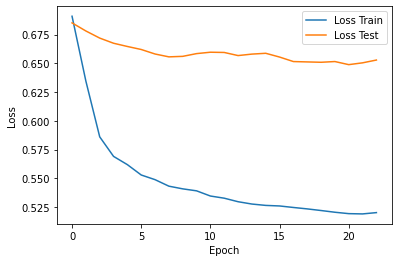

In [28]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Loss Train', 'Loss Test'], loc = 'upper right')
plt.show

Display the mse value obtained

<function matplotlib.pyplot.show(*args, **kw)>

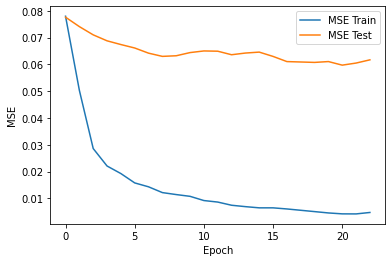

In [29]:
plt.plot(hist.history['mse'])
plt.plot(hist.history['val_mse'])
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['MSE Train', 'MSE Test'], loc = 'upper right')
plt.show

Display the recall value obtained

<function matplotlib.pyplot.show(*args, **kw)>

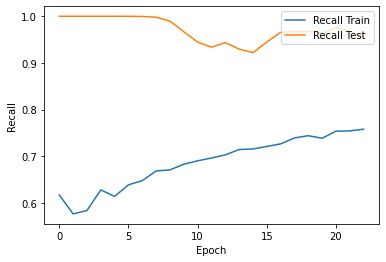

In [31]:
plt.plot(hist.history['recall'])
plt.plot(hist.history['val_recall'])
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Recall Train', 'Recall Test'], loc = 'upper right')
plt.show

Display the precission value obtained

<function matplotlib.pyplot.show(*args, **kw)>

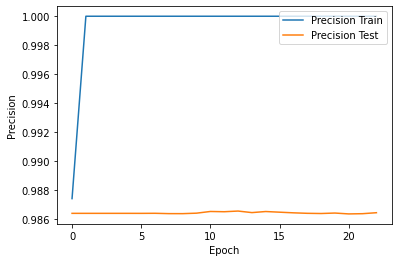

In [32]:
plt.plot(hist.history['precision'])
plt.plot(hist.history['val_precision'])
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Precision Train', 'Precision Test'], loc = 'upper right')
plt.show

Load weight model

In [33]:
def load_weight(name, model):
    weights = model.get_layer(name).get_weights()[0]
    weights = weights / np.linalg.norm(weights, axis = 1).reshape((-1, 1))
    return weights
    
movie_weights = load_weight('movie_embedding', model)
user_weights = load_weight('user_embedding', model)

Search movieId by title



In [34]:
def movie_data(movie):
    if isinstance(movie, int):
        return movie_df[movie_df.movieId == movie]
    if isinstance(anime, str):
        return movie_df[movie_df.title == movie]

Approaching the collaborative filtering technique

In [35]:
rating_by_user = rating_df.groupby('userId').size()
random_user = rating_by_user[rating_by_user < 1000].sample(1, random_state = None).index[0]

# memasukkan id user secara random
print('User ID : ', random_user)
top_movie_user = new_movie_df.groupby('userId').get_group(random_user)
top_movie_user[['rating', 'title', 'genres']].sort_values(by = 'rating', ascending = False)

User ID :  393


,rating,title,genres
55987,5.0,Dr. Horrible's Sing-Along Blog (2008),Comedy|Drama|Musical|Sci-Fi
42722,5.0,Sherlock Holmes (2009),Action|Crime|Mystery|Thriller
41747,5.0,Mr. & Mrs. Smith (2005),Action|Adventure|Comedy|Romance
54906,5.0,Inside Man (2006),Crime|Drama|Thriller
55035,5.0,Pirates of the Caribbean: Dead Man's Chest (2006),Action|Adventure|Fantasy
...,...,...,...
26861,0.5,Terminator 2: Judgment Day (1991),Action|Sci-Fi
48621,0.5,Blade Runner (1982),Action|Sci-Fi|Thriller
56653,0.5,Drive (2011),Crime|Drama|Film-Noir|Thriller
56525,0.5,Hanna (2011),Action|Adventure|Mystery|Thriller


Looking for user similarities

In [36]:
def get_similar_users(tempId, n = 10):
      index = tempId
      weights = user_weights
      dists = np.dot(weights, weights[encodedUser.get(index)])
      sortedDists = np.argsort(dists)
      n += 1
      closest = sortedDists[-n:]
      print('User that similar to user #{}'.format(tempId))
      
      SimilarArr = []
      
      for close in closest:
          similarity = dists[closest]

          if isinstance(tempId, int):
              SimilarArr.append({"similar_users" : encodeusertouser.get(close), "similarity" : similarity})

      Frame = pd.DataFrame(SimilarArr)
      return Frame

Displays a list of movie recommendations based on the user's movie viewing activity

In [37]:
def get_user_movie_preference(userId, plot = False, temp = 1):
  
  # menentukan batas rating terendah movie
  lowest_rating = np.percentile(rating_df[rating_df.userId == userId].rating, 75)
  rating_df[rating_df.userId == userId] = rating_df[rating_df.userId == userId][rating_df[rating_df.userId == userId].rating >= lowest_rating]
  top_movie_refference = (rating_df[rating_df.userId == userId].sort_values(by = "rating", ascending = False).movieId.values)
  
  user_pref_df = movie_df[movie_df["movieId"].isin(top_movie_refference)]
  user_pref_df = user_pref_df[["movieId","title", "genres"]]
  
  if temp != 0:
      print("Berikut ini adalah list rekomendasi film dari user dengan id #{} yang telah mereview {} film dengan rata-rata ratingnya adalah = {:.1f}/5.0".format(
        userId, len(rating_df[rating_df.userId==userId]),
        rating_df[rating_df.userId==userId]['rating'].mean()*5,
      ))

  return user_pref_df

Showing the top 10 recommended movies

In [38]:
reff_user = get_user_movie_preference(random_user, plot = True)
reff_user = pd.DataFrame(reff_user)
reff_user.head(10)

Berikut ini adalah list rekomendasi film dari user dengan id #393 yang telah mereview 68 film dengan rata-rata ratingnya adalah = 5.0/5.0


,movieId,title,genres
254,293,Léon: The Professional (a.k.a. The Professiona...,Action|Crime|Drama|Thriller
398,457,"Fugitive, The (1993)",Thriller
602,750,Dr. Strangelove or: How I Learned to Stop Worr...,Comedy|War
828,1089,Reservoir Dogs (1992),Crime|Mystery|Thriller
900,1198,Raiders of the Lost Ark (Indiana Jones and the...,Action|Adventure
901,1199,Brazil (1985),Fantasy|Sci-Fi
907,1206,"Clockwork Orange, A (1971)",Crime|Drama|Sci-Fi|Thriller
990,1291,Indiana Jones and the Last Crusade (1989),Action|Adventure
1211,1610,"Hunt for Red October, The (1990)",Action|Adventure|Thriller
1734,2329,American History X (1998),Crime|Drama
